<h1>Inefficacité du Perceptron</h1>

In [406]:
import pandas as pd
import numpy as np
import itertools

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Embedding, Flatten, Reshape
from keras.optimizers import Adam

<h2>Boite à outils</h2>

In [407]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    cm = cm.astype("float") / cm.sum(axis=1)

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, fontsize=20, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i,j] > 0.5 else "black"        
        plt.text(j, i, format(cm[i, j], ".2f"), horizontalalignment="center", verticalalignment="center", color=color, fontsize=40)

    plt.ylabel("Correction", fontsize=15)
    plt.xlabel("Prédiction", fontsize=15)

In [408]:
# nettoyage des données (ponctuations)

stopWords = set(stopwords.words("english"))

def cleanText(text):
    forbidden = {",","@",";","/","-",":",".","!","?", "#","\"","(",")","\'","’","‘","–","...","&"}
    res = str(text)

    if res is None:
        return ""
    
    for elm in forbidden:
        res = res.replace(elm, "")
    
    if len(res.split()) >= 30:
        res = " ".join(res.split()[0:30])
    
    for elm in forbidden:
        res = res.replace("  ", " ")
    
    return res

<h2>Traitement des données</h2>

<h3>Dataset 1</h3>

In [409]:
# chargement des deux tables
real_news = pd.read_csv("./dataset1/True.csv")
fake_news = pd.read_csv("./dataset1/Fake.csv")

# vrai = 1, faux = 0
real_news["label"] = 1
fake_news["label"] = 0

# création du dataset complet
dataframe1 = pd.concat([real_news, fake_news])

print(f"Nombre de références : {dataframe1.title.count()}")
print(f"Nombre de fake news : {fake_news.title.count()}")
print(f"Nombre de vraies news : {real_news.title.count()}")

# ici on ne s'intéresse qu'au titre et au label
del dataframe1["title"]
del dataframe1["subject"]
del dataframe1["date"]
dataframe1["text"] = dataframe1["text"].apply(cleanText)

dataframe1.sample(10)

Nombre de références : 44898
Nombre de fake news : 23481
Nombre de vraies news : 21417


,text,label
13047,I know there are only 60 days left to make our...,0
7876,Marijuana legalization is on the cusp in Ameri...,0
2739,WASHINGTON Reuters With talks to renegotiate t...,1
1860,WASHINGTON Reuters President Donald Trumps cal...,1
18764,BARCELONA Reuters Catalan separatists urged su...,1
1842,WASHINGTON Reuters US President Donald Trump s...,1
16893,The Transportation Security Administration TSA...,0
14516,JOHANNESBURG Reuters South Africa s Justice Mi...,1
9780,During game 1 of the WNBA Finals the LA Sparks...,0
3038,COLORADO SPRINGS Colo Reuters Officials with t...,1


<h3>Dataset 2</h3>

In [410]:
dataframe2 = pd.read_csv("./dataset2/train.csv")
del dataframe2["id"]
del dataframe2["author"]
del dataframe2["title"]

dataframe2["text"] = dataframe2["text"].apply(cleanText)

dataframe2.sample(10)

,text,label
5801,WASHINGTON — Attorney General Jeff Sessions fa...,0
16070,20 Views November 03 2016 GOLD KWN King World ...,1
11234,Print Protesters blocked the upper level of th...,1
2134,« on Today at 083635 PM » AIG Quadruples Limit...,1
4578,Wed 26 Oct 2016 1945 UTC © The Canary Leaked d...,1
15668,Good morning Were trying something new this we...,0
17032,License DMCA With the US more interested in fi...,1
3190,STAFFORD SPRINGS Conn — Sandra Miller was at w...,0
4575,Veteran political strategist Pat Caddell talke...,0
10752,Leaked Podestas Satanic Spirit Cooking Dinner ...,1


In [411]:
# on sépare les données en données d'entraînement et données de test (80% et 20%)
x_train, x_test, y_train, y_test = train_test_split(dataframe1["text"], dataframe1["label"], test_size=0.99, random_state = 42)
print(f"Données d'entrainement : {len(x_train)}")
print(f"Données de test : {len(x_test)}")

Données d'entrainement : 448
Données de test : 44450


In [412]:
max_features = 10000 # taille max du vocab
maxlen = 70 # taille max de séquence

In [413]:
# vectorisation naïve en "one-hot"
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(pd.concat([dataframe1["text"], dataframe2["text"]]))

In [414]:
# vectorisation des données d'entraînement
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=maxlen)

In [415]:
# vectorisation des données de test
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=maxlen)

<h2>Modèle Perceptron</h2>

In [416]:
batch_size = 128 # la batch_size n'influe pas sur le résultat non plus
nb_epochs = 100 # le nombre d'époques n'influe pas sur le résultat
embedded_dim = 100 # idem

In [417]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embedded_dim, input_length=maxlen, trainable=True))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002), metrics=["accuracy"])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 70, 100)           1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 7000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               1792256   
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 2,825,281
Trainable params: 2,825,281
Non-trainable params: 0
___________________________________________

In [418]:
progress = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs)

C:\Users\Shadow\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
448/448 [==============================] - 0s 530us/step - loss: 0.6924 - accuracy: 0.5134
Epoch 2/100
448/448 [==============================] - 0s 59us/step - loss: 0.6800 - accuracy: 0.6071
Epoch 3/100
448/448 [==============================] - 0s 65us/step - loss: 0.6642 - accuracy: 0.7143
Epoch 4/100
448/448 [==============================] - 0s 65us/step - loss: 0.6397 - accuracy: 0.8326
Epoch 5/100
448/448 [==============================] - 0s 59us/step - loss: 0.6102 - accuracy: 0.9107
Epoch 6/100
448/448 [==============================] - 0s 60us/step - loss: 0.5773 - accuracy: 0.9286
Epoch 7/100
448/448 [==============================] - 0s 61us/step - loss: 0.5370 - accuracy: 0.9821
Epoch 8/100
448/448 [==============================] - 0s 63us/step - loss: 0.4827 - accuracy: 0.9911
Epoch 9/100
448/448 [==============================] - 0s 61us/step - loss: 0.4277 - accuracy: 0.9933
Epoch 10/100
448/448 [==============================] - 0s 62us/step - loss: 0.35

448/448 [==============================] - 0s 60us/step - loss: 3.6140e-04 - accuracy: 1.0000
Epoch 80/100
448/448 [==============================] - 0s 62us/step - loss: 3.7044e-04 - accuracy: 1.0000
Epoch 81/100
448/448 [==============================] - 0s 58us/step - loss: 3.5860e-04 - accuracy: 1.0000
Epoch 82/100
448/448 [==============================] - 0s 58us/step - loss: 3.4682e-04 - accuracy: 1.0000
Epoch 83/100
448/448 [==============================] - 0s 60us/step - loss: 3.3037e-04 - accuracy: 1.0000
Epoch 84/100
448/448 [==============================] - 0s 60us/step - loss: 3.0957e-04 - accuracy: 1.0000
Epoch 85/100
448/448 [==============================] - 0s 61us/step - loss: 2.9992e-04 - accuracy: 1.0000
Epoch 86/100
448/448 [==============================] - 0s 60us/step - loss: 3.1552e-04 - accuracy: 1.0000
Epoch 87/100
448/448 [==============================] - 0s 62us/step - loss: 2.9025e-04 - accuracy: 1.0000
Epoch 88/100
448/448 [============================

<h2>Analyse des résultats</h2>

In [419]:
# art plastique du turfu featuring le poto matplotlib
from matplotlib import pyplot as plt

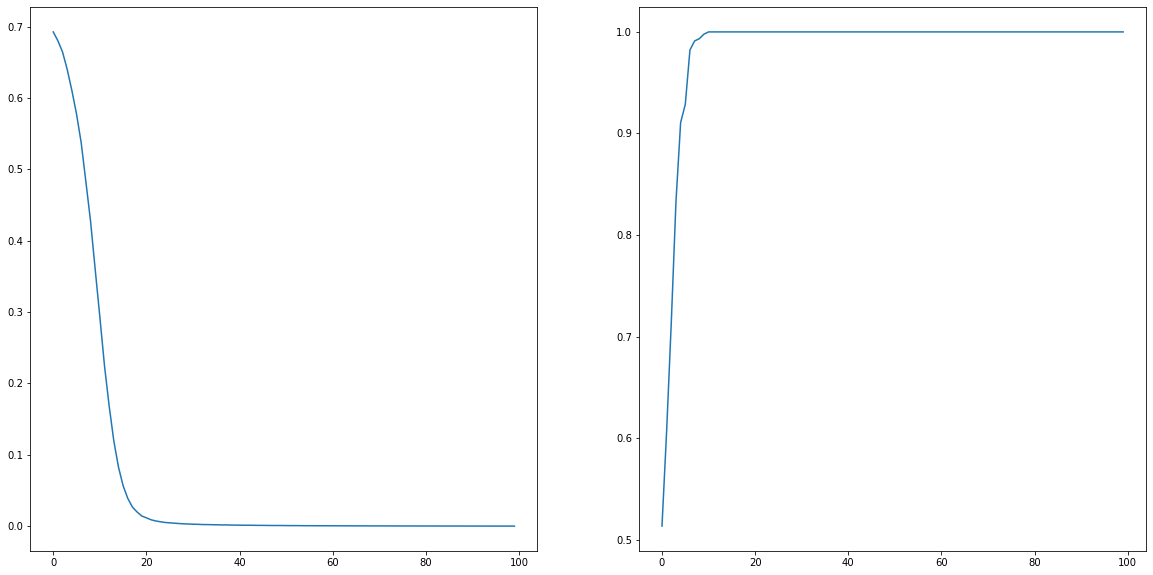

In [420]:
figure, ax = plt.subplots(1, 2)
figure.set_size_inches(20,10)

ax[0].plot(progress.history["loss"])

ax[1].plot(progress.history["accuracy"])

plt.show()

Ci dessus : mise en évidence que le nombre d'époques influe peu : le modèle devient très précis sur le dataset au bout de 20 époques

In [421]:
dataframe = pd.concat([dataframe1, dataframe2])

In [434]:
to_predict = dataframe2.sample(10000)

In [435]:
X_test = to_predict["text"]

In [436]:
Y_test = to_predict["label"]

In [437]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [438]:
predictions = model.predict(X_test)

threshold = 0.5 #la valeur du threshold n'a pas d'importance, les réseaux perceptrons ne fonctionnent pas sur ce problème
predictions[predictions > threshold] = 1
predictions[predictions <= threshold] = 0

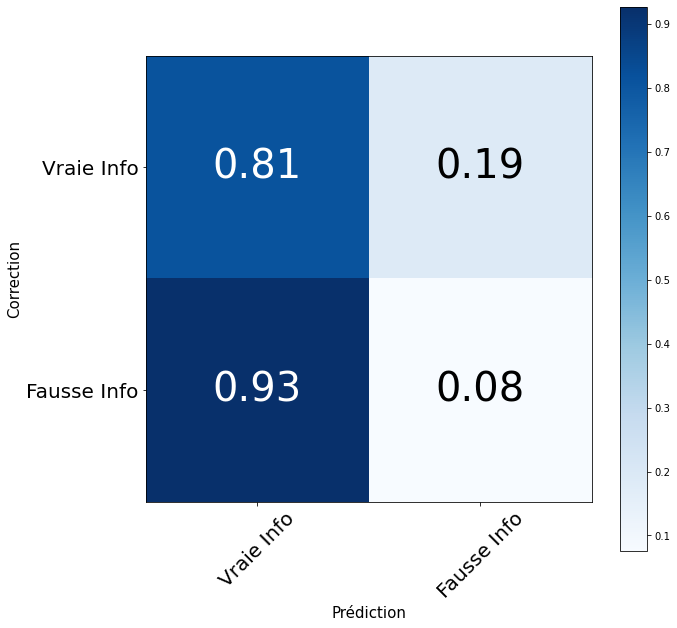

In [439]:
cm_plot_labels = ["Vraie Info", "Fausse Info"]
cm = confusion_matrix(Y_test, predictions)
plot_confusion_matrix(cm, cm_plot_labels)

Cela démontre bien qu'un réseau perceptron n'est pas capable de généraliser la notion de fake news sur un dataset sur lequel il n'a pas été entraîné.